In [1]:
#Broker imports:
import py_at_broker as pab
from IPython.display import clear_output

import pylab as pl
import pickle as p
import matplotlib.pyplot as plt
%matplotlib inline
b = pab.broker()

%load_ext autoreload
%autoreload 2
from toolbox import data_processing as dp
from toolbox import movementtoolbox as mt 
#Non broker imports:

from IPython import display
import math as math
import pandas as pd
import time
import cv2
import numpy as np
%load_ext autoreload
%autoreload 2
from toolbox import kinematic_mapping as km
from robo_cheesecake.engine import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%load_ext autoreload
%autoreload 2
from toolbox import object_detection_toolbox as odt
import os
import tensorflow as tf

from object_detection.utils import visualization_utils as vis_util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_depth_rgb_images_from_msg():
    msg = b.recv_msg("realsense_images", True)
    rgb = msg.get_rgb()
    dim_rgb = msg.get_shape_rgb()

    depth = msg.get_depth()
    dim_depth = msg.get_shape_depth()

    imrgb = np.reshape(rgb, dim_rgb)
    imdepth = np.reshape(depth, dim_depth)
    
    imdepth = cv2.resize(imdepth, dsize = (imrgb.shape[1], imrgb.shape[0]), interpolation = cv2.INTER_NEAREST)
    return (imrgb, imdepth)

In [4]:

import SLRobot



from scipy.interpolate import interp1d

from scipy import interpolate




#%matplotlib inline







pgain_null = 0.002 * np.array([600.0, 600.0, 600.0, 600.0, 250.0, 150.0, 50.0], dtype=np.float64)





# Null-space theta configuration

target_th_null = np.zeros(7, dtype=np.float64)

target_th_null[3] = -1.55

target_th_null[5] = 1.9



def quatToEulerAngles(quat):

    eulerAngles = np.array([0.0]*3)

    

    threshold = 0.001

    qw = quat[0]

    qx = quat[1]

    qy = quat[2]

    qz = quat[3]

    

    heading = np.arctan2(2.0*qy*qw-2.0*qx*qz , 1.0 - 2.0*qy*qy - 2.0*qz*qz)

    attitude = np.arcsin(2.0*qx*qy + 2.0*qz*qw)

    bank = np.arctan2(2.0*qx*qw-2.0*qy*qz , 1.0 - 2.0*qx*qx - 2.0*qz*qz)

    

    if (qx*qy + qz*qw - 0.5)*(qx*qy + qz*qw - 0.5) < threshold:

        heading = 2.0 * np.arctan2(qx,qw)

        bank = 0

        

    if (qx*qy + qz*qw + 0.5)*(qx*qy + qz*qw + 0.5) < threshold:

        heading = -2.0 * np.arctan2(qx,qw)

        bank = 0

        

    eulerAngles[0] = attitude

    eulerAngles[1] = heading

    eulerAngles[2] = bank

    

    return(eulerAngles)





def inverse_kin_6d(c_pos,q):

    J_reg = 1e-8


    # initialize the position


    J_w = np.diag([50, 50, 25, 10, 10, 5, 1])

    

    # compute the velocity in joint space and update the joint position

    qi = []

    EF_=[]

    qi.append(q)

    

    results_ =[]

    c_vel_all = []

    #while 1:
    plt.figure()

    for t in np.arange(100000):

        
        

        EF_FK = SLRobot.FK(np.array([q]))
        #print(EF_FK[0,50:56])
        c_vel = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.01])*(c_pos - EF_FK[0,50:56])

        #print(c_vel)



        J = SLRobot.Jacobian(np.array([q]), 6)



        target_th_null_out  = target_th_null

        

        A = J.dot(J_w).dot(J.transpose())

        A += J_reg * np.eye(6)



        qd_null = pgain_null * (target_th_null_out - q)

        



        qd_d = np.linalg.solve(A, c_vel - J.dot(qd_null))

        qd_d = J_w.dot(J.transpose()).dot(qd_d) + qd_null



        q = q + 0.002*qd_d

        

        

        #set the joint range

        mask_max = q > np.pi

        mask_min = q<-np.pi

        q[mask_max] = q[mask_max] - 2*np.pi

        q[mask_min] = q[mask_min] + 2*np.pi

        

        

        qi.append(q)

        EF_.append(EF_FK[0,50:56])

        

        c_vel_all.append(c_vel)

        

        

        # times the arrary to scale the orientation range.

        error_ = np.sqrt(np.sum(np.square(np.array([1.0, 1.0, 1.0, 0.08, 0.08, 0.08])*(c_pos-EF_FK[0,50:56]))))
        #print(error_)
        if error_ <0.0080:

            break

            

    print('error:', error_)



    

    qi = np.array(qi)

    

    # for debug
    
    plt.plot(qi)

    

    EF_ = np.array(EF_)

    

    c_vel_all = np.array(c_vel_all)

    return qi[-1], EF_, qi, c_vel_all







# This is a grasping point recorded by Alexj and Felix

grasp_pt_quat = np.array([ 0.6801316 ,  0.14607485,  0.07193319,  0.37495322,  0.55747047, 0.20780073,  0.58338235])

grasp_pt_angles = quatToEulerAngles(np.concatenate([grasp_pt_quat[-2:-1], grasp_pt_quat[3:6]])) #(np.array([0.37495322,  0.55747047, 0.20780073,  0.58338235]))
print(np.concatenate([grasp_pt_quat[-2:-1], grasp_pt_quat[3:6]]))
grasp_pt = np.concatenate([grasp_pt_quat[:3], grasp_pt_angles])


q = target_th_null



#input_EF = np.array([0.6801316 ,  0.14607485,  0.07193319,  0.52870199,  0.25408186, -0.11936578])

input_EF = grasp_pt
print(input_EF)

j_ik = inverse_kin_6d(input_EF,q)

end_pos=j_ik[0]



EF_FK = SLRobot.FK(np.array([end_pos]))



print('desired c pose:', input_EF)

print('c pose:', EF_FK[0,50:56])

In [5]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = '../faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/home/dlrc1/Documents/models/research/object_detection/data', 'mscoco_label_map.pbtxt')

with tf.device('/device:GPU:0'):
    detection_graph = tf.Graph()
    odt.load_model(PATH_TO_FROZEN_GRAPH, detection_graph)
    category_index = odt.create_category_index(PATH_TO_LABELS)
    with detection_graph.as_default() as graph:
        tensor_dict = odt.create_tensor_dict(['num_detections', 'detection_boxes', 'detection_scores',
        'detection_classes', 'detection_masks'])
    sess = tf.Session(graph=detection_graph)

In [6]:
b.register_signal('franka_target_pos', pab.MsgType.target_pos)

True

In [7]:
b.register_signal("franka_gripper", pab.MsgType.gripper_cmd)

True

In [8]:

def GripApple(current_counter):
    msg = pab.gripper_cmd_msg()
    msg.set_timestamp(time.clock_gettime(time.CLOCK_MONOTONIC))
    msg.set_fnumber(current_counter)
    msg.set_cmd_t(pab.CmdType.Grasp)
    msg.set_width(0.065)
    msg.set_speed(0.8)
    msg.set_force(10)

    msg.set_epsilon_in(0.005)
    msg.set_epsilon_out(0.005)

    b.send_msg("franka_gripper", msg)
    time.sleep(0.2)
    current_counter=current_counter+111
    return current_counter


def ReleaseApple(current_counter):
    msg = pab.gripper_cmd_msg()
    msg.set_timestamp(time.clock_gettime(time.CLOCK_MONOTONIC))
    msg.set_fnumber(current_counter)
    msg.set_cmd_t(pab.CmdType.Move)
    msg.set_width(80)
    msg.set_speed(0.3)
 

    b.send_msg("franka_gripper", msg)
    time.sleep(0.2)
    current_counter=current_counter+111
    return current_counter


def GoHome(current_counter):
    Home=np.array([-0.3222667,  -0.39487693,  0.25124076, -1.78770602, -0.0087735,   1.58738244,   0.85377795])
    sleep_time = samples
    go_time = samples-0.1

    frame=current_counter+1
    target_msg, current_counter = mt.create_message(counter=frame, ctrl_t = 1, pos = Home, go_time=go_time)
    b.send_msg('franka_target_pos', target_msg)
    time.sleep(sleep_time)
    
    return current_counter

In [9]:
b.request_signal("realsense_images", pab.MsgType.realsense_image)


True

In [10]:
b.request_signal("franka_state", pab.MsgType.franka_state, True)



True

In [11]:
current_counter=0

/home/dlrc1/.virtualenvs/dlrc/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


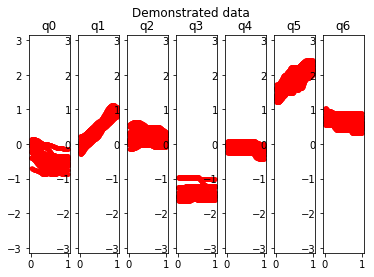

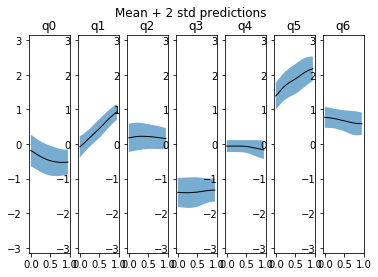

In [12]:


df_generated, N=robotoolbox.PrepareData('JointsFinalPresentation_take2.p')

params = {'D' : 7, 'K' : 5, 'N' : N}
RobotSaysHi=ProMP(identifier='RobotSaysHi', TrainingData=df_generated, params=params)
RobotSaysHi.RegularizedLeastSquares() #Choice for l from [1]
RobotSaysHi.GenerateDemoPlot(xvariable="Phases")  
RobotSaysHi.MeanAndStdPredictionPlot(factor=2)
MaxTime=8
samples=1  



def FollowMeanTrajectory(ProMP, samples, MaxTime, current_counter):
    T, Q= ProMP.GetJointData(w=ProMP.estimate_m, robotrate=samples, MaxTime=MaxTime)
    robotoolbox.PlotTrajectory(T, Q)
    plt.show()
    #time.sleep(10)
    
    sleep_time = samples
    go_time = 1.8*samples
    for idxq, Q_pos in enumerate(Q):
        print(Q_pos)
        frame=current_counter+1
        target_msg, current_counter = mt.create_message(counter=frame, ctrl_t = 1, pos = Q_pos, go_time=go_time)
        b.send_msg('franka_target_pos', target_msg)
        time.sleep(sleep_time)
        if idxq==0:

            time.sleep(2)
        
    return current_counter




/home/dlrc1/.virtualenvs/dlrc/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


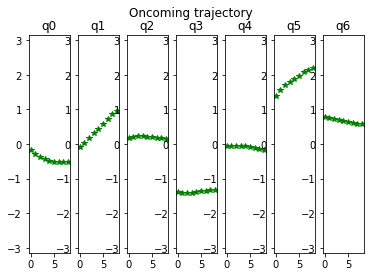

[-0.1849465  -0.07736842  0.18040424 -1.39581236 -0.05982821  1.39310514
  0.77282725]
[-0.27350867  0.0451891   0.2049821  -1.40250615 -0.05784009  1.55237353
  0.75785749]
[-0.36034917  0.17915038  0.22263234 -1.40510875 -0.05691791  1.69757158
  0.73609839]
[-0.42915407  0.31421212  0.22460486 -1.39918959 -0.05928876  1.79678189
  0.70524466]
[-0.47982367  0.44942837  0.21777614 -1.38644595 -0.0689347   1.88128965
  0.67112874]
[-0.51137303  0.59351328  0.20535082 -1.36643069 -0.09141574  1.97921238
  0.63632759]
[-0.52823366  0.73885725  0.18911504 -1.34561118 -0.12049078  2.07765848
  0.60648847]
[-0.52743756  0.8628346   0.17010112 -1.33268168 -0.14846414  2.14793478
  0.59213274]
[-0.5178315   0.96396539  0.15138092 -1.32557715 -0.17278856  2.19568246
  0.58758909]


In [17]:
current_counter=FollowMeanTrajectory(RobotSaysHi, samples, MaxTime,current_counter)

In [13]:

class RobotMap:
    
    """Map framework for robot control using lidars and cameras"""
    
    def __init__(self, ProMP, sleep_time=1, go_time=0.9, MaxTime=8):
        self.ProMP=ProMP
        self.identifier=ProMP.identifier
        self.step=0        
        self.controlsleep=True
        self.polarity=1 # Polarity is -1 when the robot goesbackwards. 
        self.Params= {'sleep_time' : sleep_time, 'go_time' :  go_time, 'MaxTime' : MaxTime}
        from toolbox import movementtoolbox as mt 
    
    def SetObjectTarget(self, Qtarget, ztarget=1):
        self.Object_Target_Qtarget=Qtarget
        self.Object_Target_ztarget=ztarget
        
    @staticmethod
    def MeanQ(z, ProMP):    
        return ProMP.GeneratePrediction(w=ProMP.estimate_m, Z=z)[1]
        
    def GeneratePath(self, ProMPconstrains=[0, 0.3, 0.5]):
        """ProMP constrains is an array that constrains via points to the mean of the ProMP"""
        
        
           
        Object_Qtarget=self.Object_Target_Qtarget
        Object_ztarget=self.Object_Target_ztarget
        
        Qtarget=[]
        Ztarget=[]
        for constrain in ProMPconstrains:
            Qtarget.append(self.MeanQ(constrain, self.ProMP))
            Ztarget.append(constrain)
        Qtarget.append(Object_Qtarget)
        Ztarget.append(Object_ztarget)                  
        w_des=self.ProMP.Condition_JointSpace(Qtarget=Qtarget, Ztarget=Ztarget)        

        T, Q= RobotSaysHi.GetJointData(w=w_des, robotrate=samples, MaxTime=MaxTime)
        
        Q[-1,:]=Object_Qtarget ## This heuristic is not very elegant but it is necesary
        robotoolbox.PlotTrajectory(T, Q)
        plt.show()
        
        self.Path=Q
        self.CurrentQ=self.Path[self.step,:]
        self.MaxSteps=self.Path.shape[0]
        
      
        
    def Execute(self):
        global current_counter
        go_time=self.Params['go_time']
        sleep_time=self.Params['sleep_time']
        
        target_msg, current_counter = mt.create_message(counter=current_counter, ctrl_t = 1, pos = self.CurrentQ, go_time=go_time)
        b.send_msg('franka_target_pos', target_msg)
        if self.controlsleep:
            time.sleep(sleep_time)
        
        current_counter+=1
        pass
    
    def DoStepForward(self):
        print("Current Step: ", self.step, ". Now moving to Step: ",self.step+1)
        self.CurrentQ=self.Path[self.step,:]
        self.step+=1
        self.Execute()

    def DoStepBack(self):
        print("Current Step: ", self.step, ". Now moving to Step: ",self.step-1)
        self.CurrentQ=self.Path[self.step,:]
        if (self.step>=1):
            self.step-=1
            self.Execute()
        else:
            pass

        
    def DoStep(self):
        if self.polarity==1:
            self.DoStepForward()
        if self.polarity==-1:
            self.DoStepBack()
            
            
        
        
    def GoToStartPosition(self):
        global current_counter
        current_counter=GoHome(current_counter)
        #current_counter=ReleaseApple(current_counter)
        time.sleep(3)
        self.Reset()

        
    def FollowBlindly(self):
        self.Execute() #Goes to step zero
        for step in range(self.step,self.MaxSteps):
            
            self.DoStepForward()
            
        
    def Reset(self):
        self.step=0
        self.CurrentQ=self.Path[self.step,:]

        
        
        
        
    


In [14]:
current_counter=GoHome(current_counter)
time.sleep(3)
current_counter=ReleaseApple(current_counter)

In [15]:
def FindObjectNN(CommonObject='apple'):
    imrgb, imdepth = get_depth_rgb_images_from_msg()
    start_time = time.time()
    output_dict = odt.run_inference_for_single_image_test(imrgb, tensor_dict, sess)
    #print('Iteration %d: %.3f sec'%(i, time.time()-start_time))
    out = odt.visualize_pred_for_single_img(imrgb, output_dict, category_index)

    Q = b.recv_msg('franka_state', -1).get_j_pos()
    result, boxes = odt.get_boxes_with_label_and_threshold(CommonObject, 0.5, output_dict, imdepth, Q, category_index)

    target_pos = np.zeros(3)
    #target_pos = np.array([0.6, 0.0, 0.1 ])
    np.copyto(target_pos, result[0,0])
    target_pos[0]  = target_pos[0]+0.005*target_pos[0]
    target_pos[1] = target_pos[1]+0.13*target_pos[1]
    target_pos[2] += 0.03

    #target_pos[1] += 0.05 #offset
    #target_pos[1] =- target_pos[1]
    #print(target_pos)
    print('result:', target_pos)

    return target_pos



In [1]:

sleep_time = samples
go_time = 1.8*samples
z=1

ApplePos=FindObjectNN(CommonObject='apple')

def IKapple(ProMP, ApplePos):
    prediction_pro=ProMP.GeneratePrediction(Z=1)[1]

    bp= SLRobot.FK(prediction_pro.reshape(1,-1))[0,50:56] # Uses the mean ProMP orientation
    bp[0:3]=ApplePos

    j_ik = inverse_kin_6d(bp,prediction_pro)
    end_pos=j_ik[0]

    EF_FK = SLRobot.FK(np.array([end_pos]))

    #print(end_pos)
    #print('desired c pose:', bp)
    #print('c pose:', EF_FK[0,50:56])



    return end_pos

    
Q_des=IKapple(RobotSaysHi, ApplePos)
#w_des=RobotSaysHi.Condition_JointSpace(Qtarget=[RobotSaysHi.GetStartPoint(w=RobotSaysHi.estimate_m), Q_des], Ztarget=[0,z])        
#w_des=RobotSaysHi.Condition_JointSpace(Qtarget=[RobotSaysHi.GetStartPoint(w=RobotSaysHi.estimate_m),PredZ(0.3) ,PredZ(0.35) , Q_des], Ztarget=[0,0.3,0.35,z])        

#T, Q= RobotSaysHi.GetJointData(w=w_des, robotrate=samples, MaxTime=MaxTime)

#Q[-1,:]=end_pos
#robotoolbox.PlotTrajectory(T, Q)

#Qp,Qpp=robotoolbox.GetAccel(Q,T)
#robotoolbox.PlotAccel(T, Qpp)
#print(Q.shape)



CurrentMap=RobotMap(ProMP=RobotSaysHi, sleep_time=sleep_time, go_time=go_time, MaxTime=MaxTime)
CurrentMap.SetObjectTarget(Q_des, ztarget=1)
CurrentMap.GeneratePath(ProMPconstrains=[0,0.3,0.4])
#CurrentMap.FollowBlindly()
#current_counter=GripApple(current_counter)
#time.sleep(0.5)
#CurrentMap.GoToStartPosition()

#current_counter=ReleaseApple(current_counter)

NameError: name 'samples' is not defined

In [2]:
AppleMomentum=False

treshold=2
while(CurrentMap.step<treshold):
    
    
    try: 
        ApplePos=FindObjectNN(CommonObject='apple')
        CurrentMap.polarity=1
        if (AppleMomentum):
            print("Recalculating...")
            Q_des=IKapple(RobotSaysHi, ApplePos)
            print("New apple pos in Task: ",ApplePos,"New apple pos in joint ", Q_des)

            CurrentMap.SetObjectTarget(Q_des, ztarget=1)
            CurrentMap.GeneratePath(ProMPconstrains=[0,0.3,0.4])
            AppleMomentum=False
    except:
            CurrentMap.polarity=-1
            AppleMomentum=True
            CurrentMap.GoToStartPosition()
            print("Apple not visible")
        
    print(CurrentMap.polarity)
    CurrentMap.DoStep()
    clear_output(wait=True)

while(CurrentMap.step<CurrentMap.MaxSteps):
    CurrentMap.DoStep()
    clear_output(wait=True)    


time.sleep(0.5)
current_counter=ReleaseApple(current_counter)
    

current_counter=GripApple(current_counter)
time.sleep(0.5) 
CurrentMap.GoToStartPosition()

#    CurrentMap.GoToStartPosition()
    



time.sleep(0.5)
current_counter=ReleaseApple(current_counter)


NameError: name 'CurrentMap' is not defined

In [3]:
current_counter=GripApple(current_counter)


NameError: name 'GripApple' is not defined

In [4]:
CurrentMap.GoToStartPosition()
current_counter=ReleaseApple(current_counter)

NameError: name 'CurrentMap' is not defined

In [5]:
CurrentMap.GoToStartPosition()
current_counter=ReleaseApple(current_counter)

NameError: name 'CurrentMap' is not defined